# Create the graph from the book example

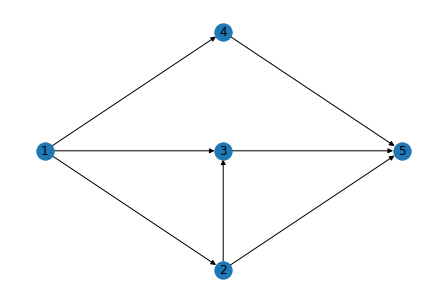

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
from typing import Any, Optional

G = nx.DiGraph()

b = [40, 50, 0, -30, -60]
edges = [(1,2), (1,3), (1,4), (2,3), (2,5), (3,5), (4,5)]
edge_data = [(3, 1000), (7, 10), (5, 35), (2, 60), (1, 30), (8, 1000), (4, 1000)]

G.add_nodes_from(zip(range(1, 6), ({"b": b[i]} for i in range(5))))
G.add_edges_from(edges)
for edge, data in zip(edges, edge_data):
    from_, to_ = edge
    cost, cap = data
    G[from_][to_]["cost"] = cost
    G[from_][to_]["cap"] = cap
    G[from_][to_]["flow"] = 0
    
nx.draw_shell(G, nlist=[[3], [1, 2, 5, 4]], with_labels=True)

# Perform network simplex
Steps:
1. Find a rooted feasible spanning tree with $m-1$ basic arcs
   - Check if $\sum b_i =0$. If not add dummy nodes and associated dummy arcs
   - Designate a demand node ($b_i < 0$>) as a root node and create a rooted arc from it
   - Create a feasible spanning tree. Begin with the end nodes and proceed toward the rooted node. Assign flows to arcs so that at each node the net flow is $b_i$


In [35]:
def find_feasible_spanning_tree(graph: nx.DiGraph):
    # This is assuming the graph is the book example, and uses their given 
    # spanning tree.
    graph[1][3]["flow"] = 10
    graph[1][4]["flow"] = 30
    graph[2][3]["flow"] = 50
    graph[3][5]["flow"] = 60
    graph.add_edge(5, "root")
    tree = [(1,3), (1,4), (2,3), (3,5), (5,"root")]
    return tree

basic_arcs = find_feasible_spanning_tree(G)
print(basic_arcs)

[(1, 3), (1, 4), (2, 3), (3, 5), (5, 'root')]


2. Compute the node potentials ($u_i$ or the dual variables). Set the rooted node to 0 and then use $u_i - u_j = c_{ij}$ to iteratively backtrack the other values.


In [36]:
def compute_duals(graph: nx.DiGraph, basic_arcs: list[tuple[Any, Any]]):
    root = basic_arcs[-1][0]
    duals: dict[Any, float] = {}
    duals[root] = 0
    
    queue = [root]
    basic_arcs_set = set(basic_arcs)
    
    while len(duals) < len(graph) - 1:
        for node in queue:
            for prev in graph.pred[node]:
                if (prev, node) not in basic_arcs_set:
                    continue
                if prev not in duals:
                    duals[prev] = graph.edges[prev, node]["cost"] + duals[node]
                    queue.append(prev)  # intentionally mutating queue during iteration
            
        for node in queue:
            for post in graph.succ[node]:
                if (node, post) not in basic_arcs_set:
                    continue
                if post == "root":
                    continue
                if post not in duals:
                    duals[post] = duals[node] - graph.edges[node, post]["cost"]
                    queue.append(post)  # intentionally mutating queue during iteration
                    
    return duals
                
    
    
duals = compute_duals(G, basic_arcs)
print(duals)

{5: 0, 3: 8, 1: 15, 2: 10, 4: 10}


3. Compute the reduced costs $\bar{c}_{ij} = u_i - u_j - c_{ij}$ for all non-basic (un-used or at capacity) arcs. Check optimality ($x_{ij}=0 \Rightarrow \bar{c}_{ij} \leq 0, x_{ij} = U_{ij} \Rightarrow \bar{c}_{ij}$). If not optimal, choose an entering arc that most violates either optimality condition.


In [37]:
def compute_reduced_costs(graph: nx.DiGraph, basic_arcs: list[tuple[Any, Any]], duals: dict[Any, float]):
    basic_arcs_set = set(basic_arcs)
    reduced_costs: dict[tuple[Any, Any], float] = {}
    for edge in graph.edges:
        if edge not in basic_arcs_set:
            u_from, u_to = duals[edge[0]], duals[edge[1]]
            cost_from_to = graph.edges[edge]["cost"]
            reduced_costs[edge] = u_from - u_to - cost_from_to
            
    return reduced_costs

reduced_costs = compute_reduced_costs(G, basic_arcs, duals)

def optimality_violations(graph: nx.DiGraph, reduced_costs: dict[tuple[Any, Any], float]):
    violations = {edge: 0.0 for edge in reduced_costs}
    for edge in reduced_costs:
        if graph.edges[edge]["flow"] == 0 and reduced_costs[edge] > 0:
            violations[edge] = reduced_costs[edge]
        if graph.edges[edge]["flow"] == graph.edges[edge]["cap"] and reduced_costs[edge] < 0:
            violations[edge] = -reduced_costs[edge]
    return violations

violations = optimality_violations(G, reduced_costs)
print(violations)

def is_optimal(violations: dict[tuple[Any, Any], float], epsilon: float = 1e-6):
    return all(abs(v) <= epsilon for v in violations.values())

print("Is optimal? " + str(is_optimal(violations)))

def entering_arc(violations: dict[tuple[Any, Any], float]):
    pass

{(1, 2): 2, (2, 5): 9, (4, 5): 6}
Is optimal? False


4. Form a unique cycle by adding the entering arc. Determine the maximum amount of $\Delta$ (either increase or decrease flow) without violating constraints. The leaving arc is the one that "hits" a constraint with this $\Delta$.


5. Find the new feasible spanning tree by adjusting the flows in the cycle so that flow conservation is maintained (i.e., add or subtract $\Delta$ appropriately). Go back to 2.